Edward那个是伪Gibbs，其实就是个利用condition分布的wrapper，如果不是真正的condition分布其实就是在随机游走。而且那个实现逻辑真是无力吐槽

PyMC3那个gibbs采样貌似只是个特殊情况，也亏得它好意思声称自己支持gibbs采样。

当然它们这些框架实现gibbs采样有自己的困难，因为无法分别到底哪些变量要分开来采样，比如Edward那个的变量替换计算图，
因为是按变量来替换而不是变量里的每个值，如果要轮换采样也只能变量之间轮换，然而它那种构造方式决定了本来也不会有很多变量（不然字典太大了），
所以提升的程度有限，也许正是这个原因它只实现了个伪Gibbs采样。

下面我要修复该MH算法实现，实现成每个latent变量都更新一次。若要实现所有标量更新，可以程序构造大字典实现这一点，不过估计也不需要这么做。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf

In [2]:
%%time
import edward as ed
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

Wall time: 20.1 s


In [20]:
# priori model test

sess = ed.get_session()
tf.global_variables_initializer().run()

In [159]:
from collections import OrderedDict
from edward.inferences.monte_carlo import MonteCarlo
from edward.models import RandomVariable
from edward.util import check_latent_vars, copy

try:
  from edward.models import Uniform
except Exception as e:
  raise ImportError("{0}. Your TensorFlow version is not supported.".format(e))


class MetropolisHastingsY(ed.MetropolisHastings):
  def build_update_step(self, index, check_latent):
    """Draw sample from proposal conditional on last sample. Then
    accept or reject the sample based on the ratio,

    .. math::
      \\text{ratio} =
          \log p(x, z^{\\text{new}}) - \log p(x, z^{\\text{old}}) +
          \log g(z^{\\text{new}} \mid z^{\\text{old}}) -
          \log g(z^{\\text{old}} \mid z^{\\text{new}})

    Notes
    -----
    The updates assume each Empirical random variable is directly
    parameterized by ``tf.Variable``s.
    """
    old_sample = {z: tf.gather(qz.params, tf.maximum(self.t - 1, 0))
                  for z, qz in six.iteritems(self.latent_vars)}
    old_sample = OrderedDict(old_sample)

    # Form dictionary in order to replace conditioning on prior or
    # observed variable with conditioning on a specific value.
    dict_swap = {}
    for x, qx in six.iteritems(self.data):
      if isinstance(x, RandomVariable):
        if isinstance(qx, RandomVariable):
          qx_copy = copy(qx, scope='conditional')
          dict_swap[x] = qx_copy.value()
        else:
          dict_swap[x] = qx

    dict_swap_old = dict_swap.copy()
    dict_swap_old.update(old_sample)
    scope_old = 'inference_' + str(index) + 'index_' + str(id(self)) + '/old'
    scope_new = 'inference_' + str(index) + 'index_' + str(id(self)) + '/new'

    # Draw proposed sample and calculate acceptance ratio.
    new_sample = old_sample.copy()  # copy to ensure same order
    ratio = 0.0
    
    '''
    for z, proposal_z in six.iteritems(self.proposal_vars):
      # Build proposal g(znew | zold).
      proposal_znew = copy(proposal_z, dict_swap_old, scope=scope_old)
      # Sample znew ~ g(znew | zold).
      new_sample[z] = proposal_znew.value()
      # Increment ratio.
      ratio += tf.reduce_sum(proposal_znew.log_prob(new_sample[z]))
    '''
    z, proposal_z = check_latent, self.proposal_vars[check_latent]
    # Build proposal g(znew | zold).
    proposal_znew = copy(proposal_z, dict_swap_old, scope=scope_old)
    # Sample znew ~ g(znew | zold).
    new_sample[z] = proposal_znew.value()
    # Increment ratio.
    ratio += tf.reduce_sum(proposal_znew.log_prob(new_sample[z]))

    dict_swap_new = dict_swap.copy()
    dict_swap_new.update(new_sample)

    '''
    for z, proposal_z in six.iteritems(self.proposal_vars):
      # Build proposal g(zold | znew).
      proposal_zold = copy(proposal_z, dict_swap_new, scope=scope_new)
      # Increment ratio.
      ratio -= tf.reduce_sum(proposal_zold.log_prob(dict_swap_old[z]))
    '''
    z, proposal_z = check_latent,self.proposal_vars[check_latent]
    # Build proposal g(zold | znew).
    proposal_zold = copy(proposal_z, dict_swap_new, scope=scope_new)
    # Increment ratio.
    ratio -= tf.reduce_sum(proposal_zold.log_prob(dict_swap_old[z]))


    for z in six.iterkeys(self.latent_vars):
      # Build priors p(znew) and p(zold).
      znew = copy(z, dict_swap_new, scope=scope_new)
      zold = copy(z, dict_swap_old, scope=scope_old)
      # Increment ratio.
      ratio += tf.reduce_sum(znew.log_prob(dict_swap_new[z]))
      ratio -= tf.reduce_sum(zold.log_prob(dict_swap_old[z]))

    for x in six.iterkeys(self.data):
      if isinstance(x, RandomVariable):
        # Build likelihoods p(x | znew) and p(x | zold).
        x_znew = copy(x, dict_swap_new, scope=scope_new)
        x_zold = copy(x, dict_swap_old, scope=scope_old)
        # Increment ratio.
        ratio += tf.reduce_sum(x_znew.log_prob(dict_swap[x]))
        ratio -= tf.reduce_sum(x_zold.log_prob(dict_swap[x]))

    # Accept or reject sample.
    u = Uniform().sample()
    accept = tf.log(u) < ratio
    sample_values = tf.cond(accept, lambda: list(six.itervalues(new_sample)),
                            lambda: list(six.itervalues(old_sample)))
    if not isinstance(sample_values, list):
      # ``tf.cond`` returns tf.Tensor if output is a list of size 1.
      sample_values = [sample_values]

    sample = {z: sample_value for z, sample_value in
              zip(six.iterkeys(new_sample), sample_values)}

    # Update Empirical random variables.
    assign_ops = []
    for z, qz in six.iteritems(self.latent_vars):
      variable = qz.get_variables()[0]
      assign_ops.append(tf.scatter_update(variable, self.t, sample[z]))

    # Increment n_accept (if accepted).
    assign_ops.append(self.n_accept.assign_add(tf.where(accept, 1, 0)))
    #return tf.group(*assign_ops)
    return assign_ops
  def build_update(self):
    assign_ops = []
    for i,z in enumerate(six.iterkeys(self.latent_vars)):
        assign_ops.extend(self.build_update_step(i,z))
    return tf.group(*assign_ops)


In [ ]:
ed.inferences.metropolis_hastings

In [127]:
oX = np.random.normal(loc=20,scale=1,size=(100))

In [128]:
loc = Normal(loc = 0.0, scale = 1.0)
scale = Normal(loc = 2.0, scale = 0.5)
X = Normal(loc = loc, scale = scale, sample_shape = 100)

In [141]:
T = 2000

iloc = np.ones([T]).astype('float32') / 1
iscale = np.ones([T]).astype('float32') / 1

qloc = Empirical(params=tf.Variable(iloc))
qscale = Empirical(params=tf.Variable(iscale))

In [142]:
gloc = Normal(loc=loc, scale=0.1)
gscale = Normal(loc=scale, scale=0.1)

In [143]:
loc,qloc,scale,qscale

(<ed.RandomVariable 'Normal_140/' shape=() dtype=float32>,
 <ed.RandomVariable 'Empirical_110/' shape=() dtype=float32>,
 <ed.RandomVariable 'Normal_143/' shape=() dtype=float32>,
 <ed.RandomVariable 'Empirical_113/' shape=() dtype=float32>)

In [144]:
oX

array([ 19.91355895,  18.40670368,  18.59969577,  18.86410579,
        20.4343901 ,  21.35427151,  19.83689155,  19.14357672,
        21.23984161,  20.34995258,  20.18520662,  20.98671172,
        21.10687748,  20.54932266,  18.18995712,  22.26882523,
        20.87928338,  18.88992544,  19.83686717,  18.85701113,
        19.79065947,  23.48198442,  18.03542564,  21.18021636,
        23.21370797,  20.98478449,  19.510328  ,  18.88790649,
        20.20241096,  19.09918505,  19.34836649,  21.42982827,
        19.23958015,  20.85271558,  21.13941018,  20.69839184,
        18.76442389,  21.2345607 ,  18.22676644,  19.1817773 ,
        21.06015233,  19.43238248,  20.87742362,  20.80199677,
        18.94888487,  19.70942664,  20.27136606,  19.62839745,
        21.76215215,  17.86213328,  18.79348855,  22.10878654,
        19.59022038,  21.52601732,  19.1210796 ,  20.62444435,
        18.61747093,  20.45265928,  19.89462126,  19.56502293,
        19.76026983,  19.07282194,  20.7963744 ,  20.38

In [145]:
inference = ed.MetropolisHastings({loc: qloc, scale: qscale},
                                {loc: gloc, scale: gscale},
                                {X: oX})

In [146]:
inference.run()

2000/2000 [100%] ██████████████████████████████ Elapsed: 2s | Acceptance Rate: 0.599


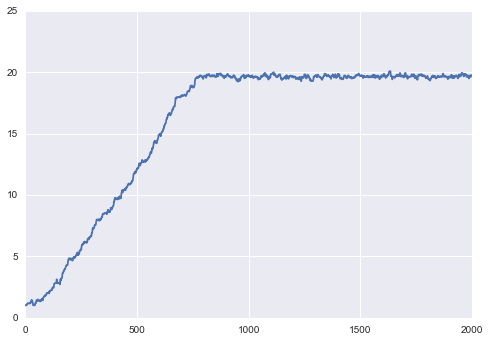

In [147]:
plt.plot(qloc.params.eval())

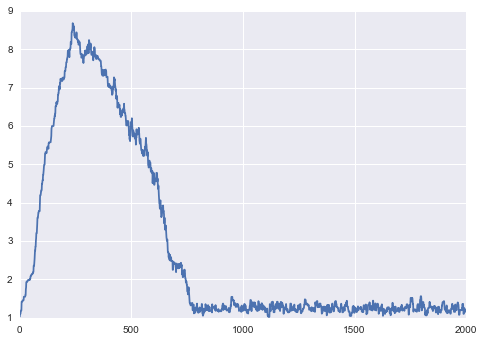

In [148]:
plt.plot(qscale.params.eval())

In [153]:
inference = MetropolisHastingsY({loc: qloc, scale: qscale},
                                {loc: gloc, scale: gscale},
                                {X: oX})

In [160]:
inference.run()

2000/2000 [100%] ██████████████████████████████ Elapsed: 2s | Acceptance Rate: 1.412


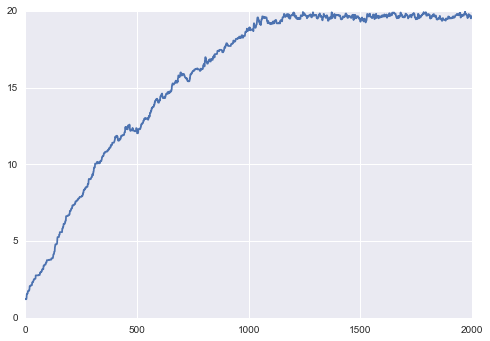

In [161]:
plt.plot(qloc.params.eval())

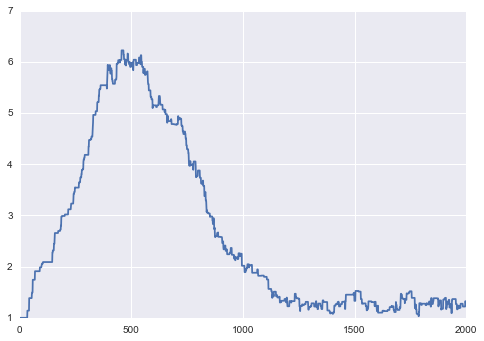

In [162]:
plt.plot(qscale.params.eval())